# Sommaire

* [Imports](#chapter1)
* [Decision Tree](#chapter2)
* [Naive Bayes](#chapter3)
* [SVM](#chapter4)
* [Random Forest](#chapter5)

### Imports <a class="anchor" id="chapter1"></a>

In [9]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import collections

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)

### Decision Tree <a class="anchor" id="chapter2"></a>

In [3]:
tfidf = pd.read_csv('/Users/emanieluu/Documents/pythonProject/ProjetPython2A/tfidf_Drake_Kanye West.csv') 

In [6]:
tfidf = tfidf.drop(["Unnamed: 0"],axis = 1)

0/200
10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200


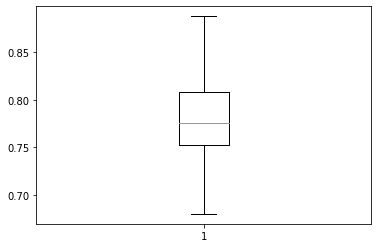

0.77748


In [9]:
list_accuracy = []
for j in range(200):
    
    if j%10 ==0 :
        print(f'{j}/200')
        
    tfidf = tfidf.sample(frac=1)
    
    rows, columns = tfidf.shape
    b = columns - 1
    X_train = tfidf.iloc[:, :-1][:int(rows // (10 / 8))] 
    X_test = tfidf.iloc[:, :-1][int(rows // (10 / 8)):] 
    y_train = tfidf.iloc[:, b:][:int(rows // (10 / 8))] 
    y_test = tfidf.iloc[:, b:][int(rows // (10 / 8)):]
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier()
    
    # Train Decision Tree Classifer
    clf = clf.fit(X_train, y_train)
    
    # Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    compteur = 0
    y_test_ = [y for y in y_test['Target']]
    for i in range(len(y_pred)):
        if y_pred[i] == y_test_[i]:
            # print('Bonne prédiction')
            compteur += 1
    list_accuracy.append(compteur / len(y_pred))

#plt.scatter(pd.DataFrame.from_dict(dict(collections.Counter(list_accuracy) ),orient='index').reset_index()['index'],
#

pd.DataFrame.from_dict(dict(collections.Counter(list_accuracy)),orient='index').reset_index()[0]
plt.boxplot(list_accuracy)
plt.show()

print(np.mean(list_accuracy))

### Naive Bayes <a class="anchor" id="chapter3"></a>

In [40]:
artist_names = ["Adele","Bruno Mars", "Drake","Eminem", "Kanye West","Lana Del Rey"]
nb_artists = len(artist_names)

In [48]:
X = []
Y = []

def tokenized_lyrics(lyrics):
    # à voir comment améliorer en supprimant les stopwords + ponctuation
    return word_tokenize(str(lyrics))

for filename in os.listdir('./artist_data'):
    data = pd.read_csv(f'./artist_data/{filename}')
    # ignore macOS files
    if filename == '.DS_Store': continue        
    artist_name = filename.replace('', '')[12:]
    data["Clean Lyrics"] = data["Clean Lyrics"].values.astype('U')
    X += data["Clean Lyrics"].values.tolist()
    for i in range(len(data)):
        #one_h = np.zeros(nb_artists) 
        #artist_index = artist_names.index(artist_name)
        #one_h[artist_index] = 1
        #add the one hot encoding to the Y array
        Y.append(artist_name)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.10,random_state=42)

In [50]:
pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

In [51]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [52]:
pipeline.score(X_test,y_test).round(2)

0.27

In [ ]:
texte = [X_test[8]]

In [ ]:
y_test[8]

In [ ]:
result = pipeline.predict_proba(texte)
print(result)

In [ ]:
print(f"The artist is: {pipeline.classes_[result.argmax()]}")

In [ ]:
pipeline.classes_

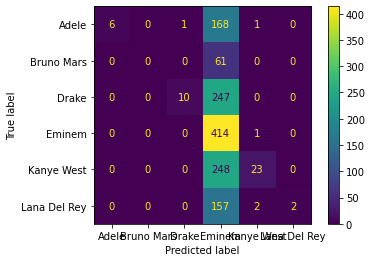

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipeline, X_train, y_train)

### SVM <a class="anchor" id="chapter4"></a>

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)

In [55]:
from sklearn.svm import SVC

clf = make_pipeline(CountVectorizer(), TfidfTransformer(), SVC(decision_function_shape = "ovr"))
clf.fit(X_train,y_train)

clf.score(X_test,y_test).round(2)

0.87

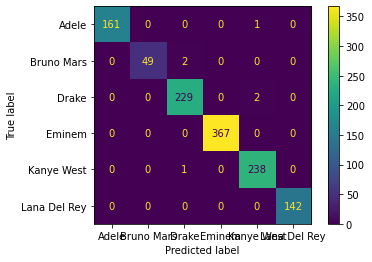

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, display_labels=clf.classes_)

### Random Forest <a class="anchor" id="chapter5"></a>

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = make_pipeline(CountVectorizer(), TfidfTransformer(), RandomForestClassifier())
clf.fit(X_train,y_train)

clf.score(X_test,y_test).round(2)

0.84

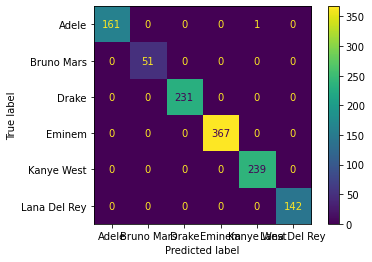

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, display_labels=clf.classes_)